<a href="https://colab.research.google.com/github/HeshanNavindu-7/oilspill-detection/blob/main/oilspill_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets

In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import opendatasets as od

In [3]:
od.download("https://www.kaggle.com/datasets/saanvitayal07/oil-spill-and-no-oil-spill")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: heshannavindu
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/saanvitayal07/oil-spill-and-no-oil-spill


100%|██████████| 26.5M/26.5M [00:00<00:00, 93.3MB/s]


In [4]:
import os
import random
import matplotlib.pyplot as plt
import cv2

#define path
dataset_dir="/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix"
class_count={}
for detection_class in os.listdir(dataset_dir):
  print(detection_class)
  class_dir= os.path.join(dataset_dir,detection_class)
  if os.path.isdir(class_dir):
    num_images=len(os.listdir(class_dir))
    class_count[detection_class]=num_images




train
test


Train Data
Displaying 4 samples from 'nospill' class:
Displaying 4 samples from 'oilspill' class:


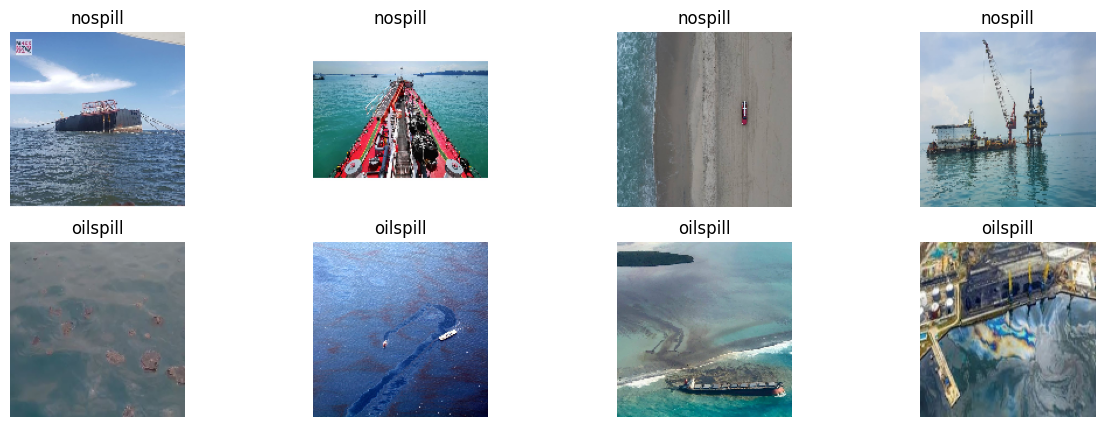

Test Data
Displaying 4 samples from 'nospill' class:
Displaying 4 samples from 'oilspill' class:


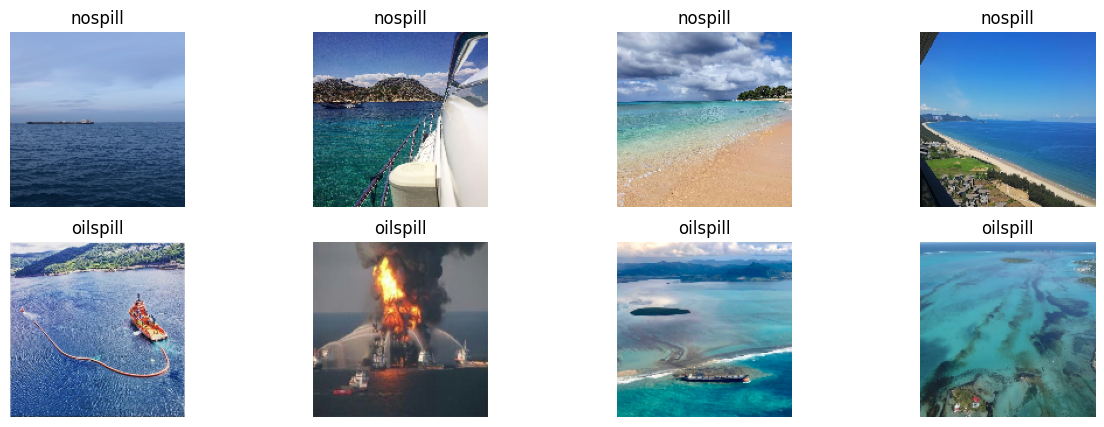

In [5]:
import cv2
import matplotlib.pyplot as plt
import os

# Define subdirectories for train and test data
train_dir = '/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix/train'
test_dir = '/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix/test'

# Define image size and batch size
target_size = (150, 150)
batch_size = 32

# Define classes
classes = ['nospill', 'oilspill']

# Display sample data
def display_sample(directory, num_samples=4):
    fig, axs = plt.subplots(len(classes), num_samples, figsize=(15, 5))
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(directory, class_name)
        print(f"Displaying {num_samples} samples from '{class_name}' class:")

        for j, filename in enumerate(os.listdir(class_dir)):
            if j >= num_samples:
                break
            img_path = os.path.join(class_dir, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, target_size)  # Resize image
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            axs[i, j].set_title(class_name)
    plt.show()

print("Train Data")
display_sample(train_dir)
print("Test Data")
display_sample(test_dir)


In [75]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define directories (adjust these paths to your setup)
train_dir = '/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix/train'
test_dir = '/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix/test'

# Define image size and batch size
target_size = (150, 150)
batch_size = 32
img_width, img_height = 150, 150

# Create ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Adjust rotation range
    width_shift_range=0.2,  # Adjust width shift range
    height_shift_range=0.2,  # Adjust height shift range
    shear_range=0.2,  # Adjust shear range
    zoom_range=0.1,  # Adjust zoom range
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# For validation, we only rescale
validation_datagen = ImageDataGenerator(rescale=1./255)

# Create the train and validation generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Function to display augmented images
def display_augmented_images(generator, num_images=5):
    # Get a batch of images and labels
    sample_data, _ = next(generator)

    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = sample_data[i]
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.show()

# Display augmented images (optional, uncomment to see)
# print("Augmented Images")
# display_augmented_images(train_generator, num_images=5)

# Load VGG16 model with pre-trained weights, excluding the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  # Experiment with number of units
x = Dropout(0.5)(x)  # Experiment with dropout rate
predictions = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Train the model (training loop not included here for brevity)
# You can use model.fit(train_generator, validation_data=validation_generator, ...)
print(model.summary())

Found 197 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                            

# test

In [77]:
!pip install visualkeras

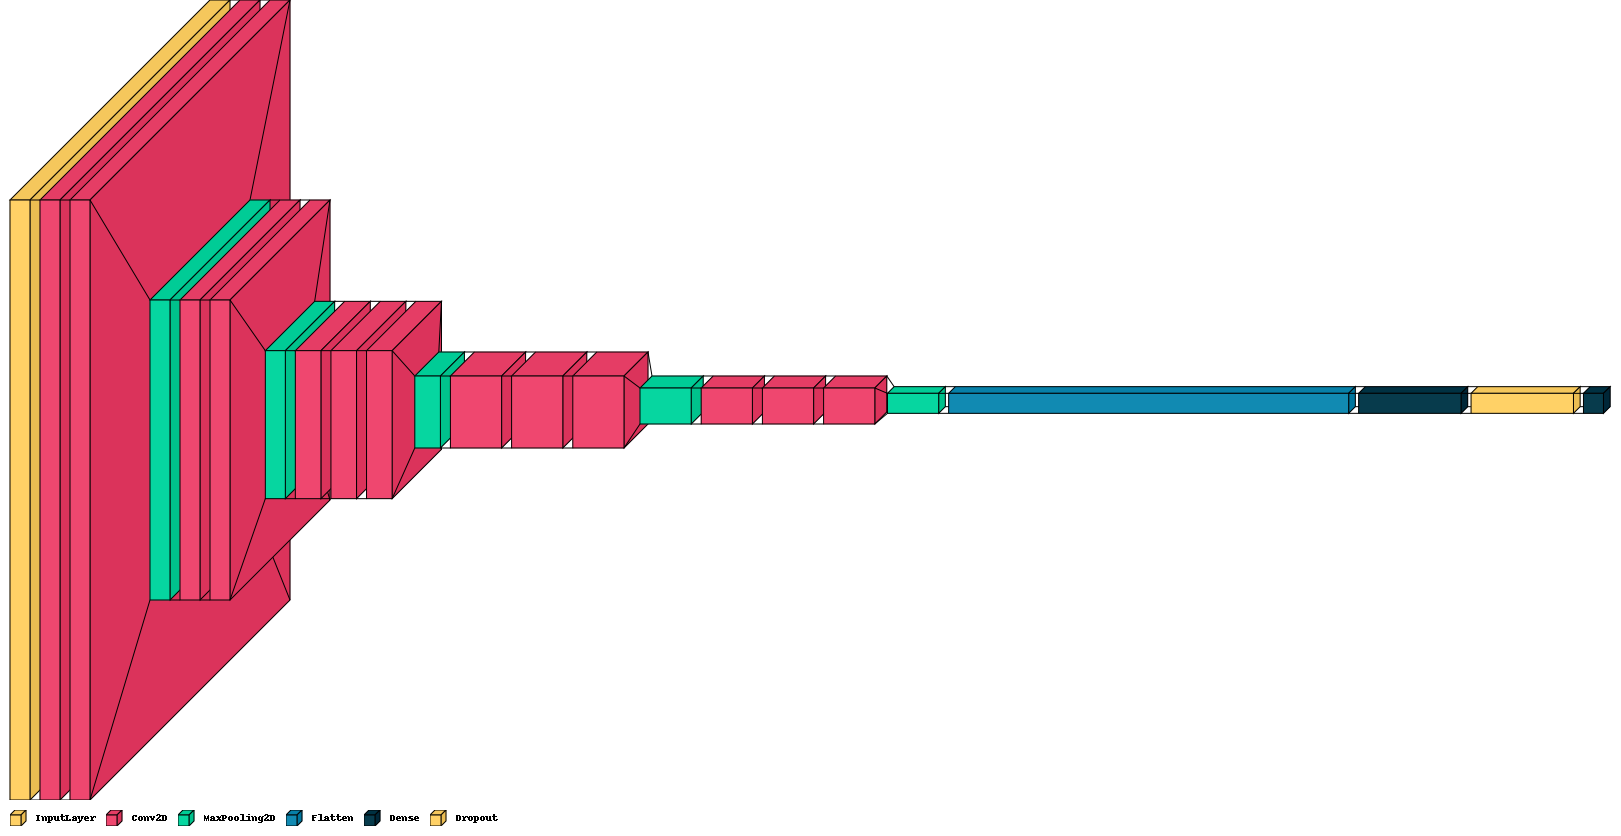

In [78]:
import visualkeras
visualkeras.layered_view(model, legend=True)

In [80]:
# Include Early Stopping (optional)
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

# Train the model
model.fit(
    train_generator,
    epochs=15,  # Adjust number of epochs
    validation_data=validation_generator,
  #  callbacks=[early_stopping]  # Uncomment to include early stopping
)


Epoch 1/15
7/7 [==============================] - 61s 9s/step - loss: 0.6171 - accuracy: 0.7614 - val_loss: 0.4816 - val_accuracy: 0.7347
Epoch 2/15
7/7 [==============================] - 63s 9s/step - loss: 0.4856 - accuracy: 0.8426 - val_loss: 0.4961 - val_accuracy: 0.7959
Epoch 3/15
7/7 [==============================] - 62s 9s/step - loss: 0.3816 - accuracy: 0.8426 - val_loss: 0.5091 - val_accuracy: 0.8367
Epoch 4/15
7/7 [==============================] - 62s 10s/step - loss: 0.3911 - accuracy: 0.8274 - val_loss: 0.5237 - val_accuracy: 0.6939
Epoch 5/15
7/7 [==============================] - 63s 9s/step - loss: 0.4569 - accuracy: 0.7817 - val_loss: 0.5079 - val_accuracy: 0.7143
Epoch 6/15
7/7 [==============================] - 61s 9s/step - loss: 0.3470 - accuracy: 0.8477 - val_loss: 0.4726 - val_accuracy: 0.7551
Epoch 7/15
7/7 [==============================] - 62s 10s/step - loss: 0.4186 - accuracy: 0.8020 - val_loss: 0.5749 - val_accuracy: 0.7143
Epoch 8/15
7/7 [================

In [81]:
# Define the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),  # Resize images to 150x150
    batch_size=batch_size,
    class_mode='binary'  # Since it's a binary classification task
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Found 49 images belonging to 2 classes.
2/2 [==============================] - 12s 3s/step - loss: 0.5219 - accuracy: 0.7347
Test Loss: 0.5218721628189087
Test Accuracy: 0.7346938848495483


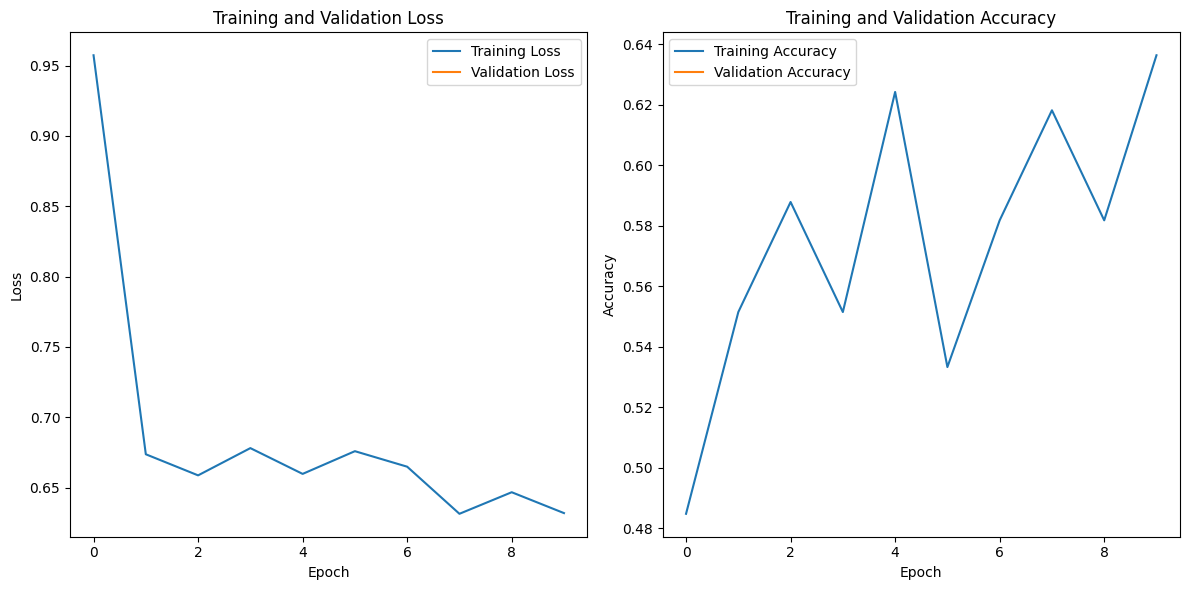

In [82]:
import matplotlib.pyplot as plt

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot training and validation loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

# Plot training and validation accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

# Adjust layout
plt.tight_layout()
plt.show()
